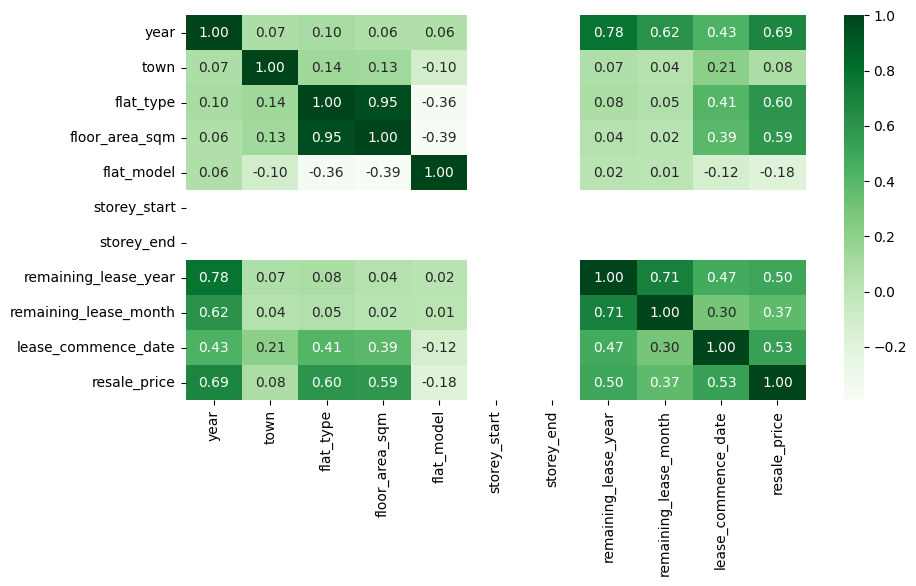

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

# Reading datasets
df_1 = pd.read_csv(r"C:\Users\admin\Desktop\Guvi-Data Science\Streamlit\ResaleFlatPricesBasedonApprovalDate19901999.csv")
df_2 = pd.read_csv(r"C:\Users\admin\Desktop\Guvi-Data Science\Streamlit\ResaleFlatPricesBasedonApprovalDate2000Feb2012.csv")
df_3 = pd.read_csv(r"C:\Users\admin\Desktop\Guvi-Data Science\Streamlit\ResaleFlatPricesBasedonRegistrationDateFromMar2012toDec2014.csv")
df_4 = pd.read_csv(r"C:\Users\admin\Desktop\Guvi-Data Science\Streamlit\ResaleFlatPricesBasedonRegistrationDateFromJan2015toDec2016.csv")
df_5 = pd.read_csv(r"C:\Users\admin\Desktop\Guvi-Data Science\Streamlit\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")

# Concatenating all dataframes
df_all = pd.concat([df_1, df_2, df_3, df_4, df_5], axis=0).reset_index(drop=True)

# Data preprocessing
df_all["address"] = df_all["block"] + " " + df_all["street_name"]
df_all["month"] = pd.to_datetime(df_all["month"], format="%Y-%m")
df_all["year"] = df_all["month"].dt.year
df_all["month"] = df_all["month"].dt.month

# Encoding categorical columns
df_all["town"] = LabelEncoder().fit_transform(df_all["town"])
df_all["flat_model"] = OrdinalEncoder().fit_transform(df_all[["flat_model"]])
df_all["flat_type"] = OrdinalEncoder().fit_transform(df_all[["flat_type"]])

# Splitting "remaining_lease" into "remaining_lease_year" and "remaining_lease_month"
slice_values = []
for i in df_all["remaining_lease"].astype(str):
    j = i.replace("years", "").replace("months", "").replace("month", "").strip()
    n = j.split()
    if len(n) == 1:
        n.append('0')
    slice_values.append(n)

df_data = pd.DataFrame(slice_values, columns=["remaining_lease_year", "remaining_lease_month"])
df_data["remaining_lease_year"] = df_data["remaining_lease_year"].replace('nan', '0').astype(int)
df_data["remaining_lease_month"] = df_data["remaining_lease_month"].replace('nan', '0').astype(int)

# Dropping the "remaining_lease" column and concatenating the new dataframe
df_all = df_all.drop(columns=["remaining_lease"])
df_all = pd.concat([df_all, df_data], axis=1)

# Ensuring columns exist
expected_columns = ['storey_start', 'storey_end']
for col in expected_columns:
    if col not in df_all.columns:
        df_all[col] = np.nan  # or any other appropriate default value

# Reordering and sorting the columns
df_all = df_all[['year', 'month', 'town', 'flat_type', 'floor_area_sqm', 'flat_model', 'address',
                 'storey_start', 'storey_end', 'remaining_lease_year', 'remaining_lease_month',
                 'lease_commence_date', 'resale_price']]
df_all = df_all.sort_values(by=["year", "month"])

# Save the cleaned dataframe to a new CSV
df_all.to_csv("cleaned_resale_flat_prices.csv", index=False)

# Removing duplicate entries
df_all = df_all.drop_duplicates().reset_index(drop=True)

# Dropping columns with low correlation
df_all = df_all.drop(columns=["month", "address"])

# Handling skewness
df_all["storey_start"] = np.log(df_all["storey_start"] + 1)
df_all["storey_end"] = np.log(df_all["storey_end"] + 1)
df_all["resale_price"] = np.log(df_all["resale_price"])

# Handling outliers using Interquartile Range (IQR) method
def outlier_correction(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

outlier_columns = ["floor_area_sqm", "storey_start", "storey_end", "resale_price"]
for column in outlier_columns:
    outlier_correction(df_all, column)

# Filling missing values
df_all = df_all.fillna(df_all.median())

# Correlation heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df_all.corr(), annot=True, cmap="Greens", fmt=".2f")
plt.show()

# Train-Test Split
X = df_all.drop(columns=["resale_price"])
y = df_all["resale_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to select and evaluate models

# Function to select and evaluate models
def select_model(df, algorithm):
    # Checking for NaN values in X
    if df.isnull().values.any():
        print("Data contains NaN values. Please handle missing values.")
        return
    
    model = algorithm().fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = {
        "Data": "Train Data",
        "Algorithm": algorithm.__name__,
        "R2_score": r2_score(y_train, y_pred_train),
        "Mean_squared_error": mean_squared_error(y_train, y_pred_train),
        "Root_mean_squared_error": np.sqrt(mean_squared_error(y_train, y_pred_train)),
        "Mean_absolute_error": mean_absolute_error(y_train, y_pred_train)
    }
    test_metrics = {
        "Data": "Test Data",
        "Algorithm": algorithm.__name__,
        "R2_score": r2_score(y_test, y_pred_test),
        "Mean_squared_error": mean_squared_error(y_test, y_pred_test),
        "Root_mean_squared_error": np.sqrt(mean_squared_error(y_test, y_pred_test)),
        "Mean_absolute_error": mean_absolute_error(y_test, y_pred_test)
    }

    print(train_metrics)
    print(test_metrics)
    print("")

# Selecting models and printing metrics
select_model(df_all, LinearRegression)
select_model(df_all, DecisionTreeRegressor)
select_model(df_all, RandomForestRegressor)
select_model(df_all, AdaBoostRegressor)
select_model(df_all, ExtraTreesRegressor)
select_model(df_all, GradientBoostingRegressor)
select_model(df_all, XGBRegressor)
